<a href="https://colab.research.google.com/github/candycreeper13/stuff/blob/main/W2025/Assignments/A3/SYSC4415_W25_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Assignment 3

**TA: [Igor Bogdanov](mailto:igorbogdanov@cmail.carleton.ca)**

## General Instructions:

This Assignment can be done **in a group of two or individually**.

YOU HAVE TO JOIN A GROUP ON BRIGHTSPACE TO SUBMIT.

Please state it explicitly at the beginning of the assignment.

You need only one submission if it's group work.

Please print out values when asked using Python's print() function with f-strings where possible.

Submit your **saved notebook with all the outputs** to Brightspace, but ensure it will produce correct outputs upon restarting and click "runtime" → "run all" with clean outputs. Ensure your notebook displays all answers correctly.

## Your Submission MUST contain your signature at the bottom.

### Objective:
In this assignment, we build a reasoning AI agent that facilitates ML operations and model evaluation. This assignment is heavily based on Tutorial 9.

**Submission:** Submit your Notebook as a *.ipynb* file that adopts this naming convention: ***SYSC4415_W25_A3_NameLastname.ipynb*** on *Brightspace*. No other submission (e.g., through email) will be accepted. (Example file name: SYSC4415_W25_A3_IgorBogdanov.ipynb or SYSC4415_W25_A3_Student1_Student2.ipynb) The notebool MUST contain saved outputs

**Runtime tips:**
Agentic programming and API calling can be easily done locally and moved to Colab in the final stages, depending on the implementation of your tools and ML tasks you want to run.

# Imports

Some basic libraries you need are imported here. Make sure you include whatever library you need in this entire notebook in the code block below.

If you are using any library that requires installation, please paste the installation command here.
Leave the code block below if you are not installing any libraries.

In [ ]:
# Name:
# Student Number:

# Name:
# Student Number:

In [ ]:
# Libraries to install - leave this code block blank if this does not apply to you
# Please add a brief comment on why you need the library and what it does


In [14]:
!pip install groq

# Libraries you might need
# General
import os
import zipfile
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# For pre-processing
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# For modeling
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchsummary

# For metrics
from sklearn.metrics import  accuracy_score
from sklearn.metrics import  precision_score
from sklearn.metrics import  recall_score
from sklearn.metrics import  f1_score
from sklearn.metrics import  classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import confusion_matrix

# Agent
from groq import Groq
from dataclasses import dataclass
import re
from typing import Dict, List, Optional


# Task 1: Registration and API Activation (5 marks)

For this particular assignment, we will be using GroqCloud for LLM inference. This task aims to determine how to use the Groq API with LLMs.  

Create a free account on https://groq.com/ and generate an API Key. Don't remove your key until you get your grade. Feel free to delete your API key after the term is completed.

In conversational AI, prompting involves three key roles: the system role (which sets the agent's behavior and capabilities), the user role (which represents human inputs and queries), and the assistant role (which contains the agent's responses). The system role provides the foundational instructions and constraints, the user role delivers the actual queries or commands, and the assistant role generates contextual, step-by-step responses following the system's guidelines. This structured approach ensures consistent, controlled interactions where the agent maintains its defined behavior while responding to user needs, with each role serving a specific purpose in the conversation flow.


In [15]:
# Q1a (2 mark)
# Create a client using your API key.

client = Groq(api_key="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")


In [16]:
# Q1b (3 marks)

# instantiate chat_completion object using model of your choice (llama-3.3-70b-versatile - recommended)
# Hint: Use Tutorial 9 and Groq Documentation
# Explain each parameter and how each value change influences the LLM's output.
# Prompt the model using the user role about anything different from the tutorial.

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user", # Defining the role, could be system or user.
            "content": "Explain the importance of low latency LLMs in one sentence" # The prompt
        }
    ],
    model="llama-3.3-70b-versatile",   # Model being used
    max_tokens=50,      # The maximum alowed tokens or word length that it will generate.
    temperature=0.5,     # Controls the randomness. Higher means more random.
    top_p=0.9,          # Controls the diversity from sampling. Higher means more diversity.
    frequency_penalty=0.2, # Penalizes frequent words or tokens (can make output less repetitive)
    presence_penalty=0.3,  # Penalizes new topics or introducing new concepts (reduces drifting from prompt)
    stop=None,        # Stop words that will stop the message.
    stream=False,     # If true, partial messages can be sent.
)
print(chat_completion.choices[0].message.content)


Low latency Large Language Models (LLMs) are crucial for enabling real-time and interactive applications, such as conversational AI, voice assistants, and live language translation, by providing rapid response times that mimic human-like conversation and improve overall user experience.


# Task 2: Agent Implementation (5 marks)

This task contains an implementation of the agent from Tutorial 9. The idea of this task is to make sure you understand how basic LLM-Agent works.


In [17]:
# Q2a: (5 marks) Explain how agent implementation works, providing comments line by line.
# This paper might be helpful: https://react-lm.github.io/

@dataclass
class Agent_State: # Creates a class to store the current messages and system prompt
    messages: List[Dict[str, str]] # Message holds a list of pairs of data. In this case, "role": "message".
    system_prompt: str # String containing the system prompt.

class ML_Agent: # Creates a class to stores ML agent memory and states.
    def __init__(self, system_prompt: str): # Initializes name and system prompt
        self.client = client # Defines the client to connects the agent to model
        self.state = Agent_State( # starts the message list with the system promp and stores it
            messages=[{"role": "system", "content": system_prompt}], # Sets the message
            system_prompt=system_prompt, # Sets the system prompt
        )

    def add_message(self, role: str, content: str) -> None: # Adds a message to the list with inputs, agent name, role and content
        self.state.messages.append({"role": role, "content": content}) # adds the message to the list

    def execute(self) -> str: # Sends the list of messages to the LLM and gets a response
        completion = self.client.chat.completions.create(
            model="llama-3.3-70b-versatile", # Sets LLM model
            temperature=0.2, # Sets randomness
            top_p=0.7, # Sets diversity
            max_tokens=1024, # Sets max token count
            messages=self.state.messages, # Gets full chat history
        )
        return completion.choices[0].message.content # Returns the response

    def __call__(self, message: str) -> str: # Lets you call the agent function with inputs for the agent and initial question.
        self.add_message("user", message) # Executes "add message" def with the inputed message
        result = self.execute() # Executes "execute" def to receive the response
        self.add_message("assistant", result) # Adds the result to message history.
        return result # Returns agent's reply

# Task 3: Tools (20 marks)

Tools are specialized functions that enable AI agents to perform specific actions beyond their inherent capabilities, such as retrieving information, performing calculations, or manipulating data. Agents use tools to decompose complex reasoning into observable steps, extend their knowledge beyond training data, maintain state across interactions, and provide transparency in their decision-making process, ultimately allowing them to solve problems they couldn't tackle through reasoning alone.

Essentially, tools are just callback functions invoked by the agent at the appropriate time during the execution loop.

You need to plan your tools for each particular task your agent is expected to solve.
The Model Evaluation Agent we are building should be able to evaluate the model from the model pool on the specific dataset.

Datasets to use: Penguins, Iris, CIFAR-10

You should be able to tell the agent what to do and watch it display the output of the tools' execution, similar to that in Tutorial 9.

User Prompt examples you should be able to give to your agent and expect it to fulfill the task:
- **Evaluate Linear Regression Model on Iris Dataset**
- **Train a logistic regression model on the Iris dataset**
- **Load the Penguins dataset and preprocess it.**
- **Train a decision tree model on the Penguins dataset and evaluate it.**
- **Load the CIFAR-10 dataset and train Mini-ResNet CNN, visualize results**

Classifier Models for Iris and Penguins (use A1 and early tutorials):
  * Logistic Regression (solver='lbfgs')
  * Decision Tree (max_depth=3)
  * KNN (n_neighbors=5)

Any 2 CNN models of your choice for CIFAR-10 dataset (do some research, don't create anything from scratch unless you want to, use the ones provided by libraries and frameworks)

HINT: It is highly recommended that any code from previous assignments and tutorials be reused for tool implementation.

**Use Pytorch where possible**

## DON'T FORGET TO IMPORT MISSING LIBRARIES

In [18]:
# Q3a (3 marks): Implement model_memory tool.
# This tool should provide the agent with details about models or datasets
# Example: when asked about Penguin dataset, the agent can use memory to look up
# the source to obtain the dataset.

def model_memory(model: str) -> str:
  """
  Provides details about the model.

  Arg: Model string

  Returns:Source to obtain the dataset?
  """
  datasets = {
        "penguins": "Available at seaborn library: `sns.load_dataset('penguins')`",
        "iris": "Available at scikit-learn: `load_iris()`",
        "cifar-10": "Available at torchvision: `torchvision.datasets.CIFAR10`",
        "logistic regression": "Logistic regression from sklearn, solver='lbfgs'",
        "decision tree": "Decision tree classifier from sklearn, max_depth=3",
        "knn": "K Neighbors classifier from sklearn, n_neighbors=5",
        "cnn": "Use MiniResNet or ResNet18 from torchvision.models"
  }

  return datasets.get(model.lower(), f"No dataset found for {model}")

# Test
print(model_memory("penguins"))

Available at seaborn library: `sns.load_dataset('penguins')`


In [64]:
# Q3b (3 marks): Implement dataset_loader tool.
# loads dataset after obtaining info from memory
from torchvision import datasets

def dataset_loader(dataset: str) -> 'DataFrame':
  """
  Loads dataset

  Arg: Dataset source.

  Returns: Dataset matrix.
  """

  if dataset.lower() == "penguins":
    return sns.load_dataset('penguins')

  elif dataset.lower() == "iris":
    #iris = load_iris(as_frame=True)
    url = 'https://github.com/rhiever/Data-Analysis-and-Machine-Learning-Projects/raw/master/example-data-science-notebook/iris-data.csv'
    return pd.read_csv(url)

  elif dataset.lower() == "cifar-10":
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
    return trainset, testset

  else:
    return "Dataset was not recognized."

# Test
print(dataset_loader("penguins").head())

  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female  


In [70]:
# Q3c (3 marks): Implement dataset_preprocessing tool.
# preprocesses the dataset to work with the chosen model, and does the splits

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

"""
Splits data.

Arg: Dataset matrix, target feature.

Returns: 4 matrices, X, y both train and test.
"""

def dataset_preprocessing(dataset, target_feature: str):
    dataset = dataset.dropna() #removes missing values
    X = dataset.drop(columns=[target_feature]) #removes column from dataset assignes to X
    y = dataset[target_feature] # extracts the target column to y

    if y.dtype == "object":
        y = LabelEncoder().fit_transform(y)

    X = pd.get_dummies(X)
    X = StandardScaler().fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

    return X_train, X_test, y_train, y_test

# Test
#print(dataset_preprocessing(dataset_loader("iris"), "class"))

In [82]:
# Q3d (3 points): Implement train_model tool.
# trains selected model on selected dataset, the agent should not use this tool
# on datasets and models that cannot work together.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

"""
Trains selected models.

Arg: Name of model, training data X, training data y.

Returns: the training model
"""

def train_model(name: str, X_train, y_train):

  if name.lower() == "logistic regression":
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train, y_train)
    return model
  elif name.lower() == "decision tree":
    model = DecisionTreeClassifier(max_depth=4)
    model.fit(X_train, y_train)
    return model
  elif name.lower() == "knn":
    model = KNeighborsClassifier(n_neighbors=7)
    model.fit(X_train, y_train)
    return model
  else:
    return ("Model not recognized.")

# Test
train = dataset_preprocessing(dataset_loader("iris"), "class")
print(train_model("logistic regression",train[0],train[2]))

LogisticRegression()


In [88]:
# Q3e (3 marks): Implement evaluate_model tool
# evaluates the models and shows the quality metrics (accuracy, precision, and anything else of your choice)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

"""
Evaluates models.

Arg: model, test data X, test data y.

Returns: the metrics
"""

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average='weighted'),
        "recall": recall_score(y_test, y_pred, average='weighted'),
        "f1": f1_score(y_test, y_pred, average='weighted')
    }

    return metrics

# Test
train = dataset_preprocessing(dataset_loader("iris"), "class")
model1 = train_model("logistic regression",train[0],train[2])
print(evaluate_model(model1,train[1],train[3]))

{'accuracy': 0.9310344827586207, 'precision': 0.903448275862069, 'recall': 0.9310344827586207, 'f1': 0.9147005444646097}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


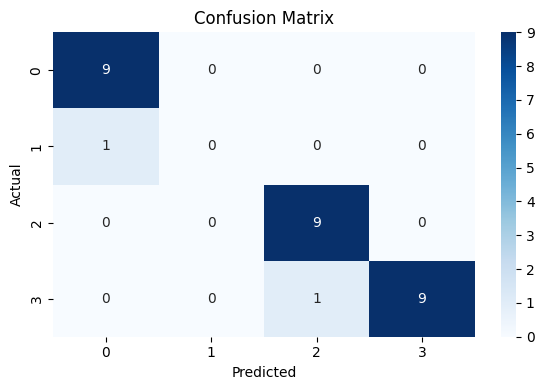

<ipython-input-94-39789fab4ca5>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="mako")


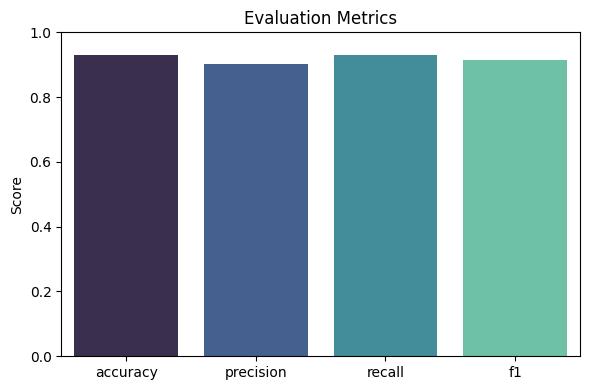

In [94]:
# Q3f (5 marks): Implement visualize_results tool
# provides results of the training/evaluation, open-ended task (2 plots minimum)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

"""
Creates plots.

Arg: model, test data X, test data y, metrics from evaluate model funciton.

"""

def visualize_results(model, X_test, y_test, metrics: dict):
    # Confusion Matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Bar Plot using precomputed metrics
    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="mako")
    plt.ylim(0, 1)
    plt.title("Evaluation Metrics")
    plt.ylabel("Score")
    plt.tight_layout()
    plt.show()

# Test
train = dataset_preprocessing(dataset_loader("iris"), "class")
model1 = train_model("logistic regression",train[0],train[2])
metrics1 = evaluate_model(model1,train[1],train[3])
visualize_results(model1,train[1],train[3],metrics1)

# Task 4: System Prompt (10 marks)
A system prompt is essential for guiding an agent's behavior by establishing its purpose, capabilities, tone, and workflow patterns. It acts as the "personality and instruction manual" for the agent, defining the format of interactions (like using Thought/Action/Observation steps in our ML agent), available tools, response styles, and domain-specific knowledge—all while remaining invisible to the end user. This hidden layer of instruction ensures the agent consistently follows the intended reasoning process and operational constraints while providing appropriate and helpful responses, effectively serving as the blueprint for the agent's behavior across all interactions.


In [98]:
# Q4a (10 marks) Build a system prompt to guide the agent based on Tutorial 9.
# Use the following function:

# Try to find alternative wording to keep the agent in the desired loop,
# don't just copy the prompt from the tutorial.

# Penalty for direct copy - 2 marks

def create_agent():
    system_prompt = """
    You operate by thinking through and taking structured actions to investigate and solve ML-related questions.
    You strictly follow the loop of: Thought → Action → PAUSE → Observation
    There thought explain your reasoning about the current task and what steps neet to be taken to achive the task.
    Actions are that you use tools to perform the task and format it like this: tool_name[arguments]
    -Observation: Show the result of the action returned by the tool and use it for your next step

    At the end of your reasoning, provide a final Answer.

    Use Thought to reflect on what the question requires or what you need to do next.
    Use Action to call one of your available tools. Always return PAUSE after an Action.
    Observation is the result of the tool or action you used.

    Your available tools are:
    - model_memory: model_memory: logistic regression vs decision tree
      Retrieves info or comparison about ML concepts, models, or parameters.

    - train_model: train_model: model_name, X_train, y_train
      Trains a specified model using provided training data.

    - evaluate_model: evaluate_model: model, X_test, y_test
      Evaluates a trained model on test data and returns metrics.

    - visualize_results: visualize_results: model, X_test, y_test, metrics
      Displays plots such as confusion matrix and evaluation metrics.

    Please remember to:
    – Stick to the loop: Thought → Action → PAUSE → Observation → (repeat) → Answer.
    – Do not skip steps or make assumptions without observations.
    – Do not invent tools not listed above.
    – Only output Answer when you're ready to conclude.

    Thanks <3
    """.strip()

    return ML_Agent(system_prompt)




# Task 5: Set the Agent Loop (10 marks)

Now we are building automation of our Thought/Action/Observation sequence.


In [ ]:
# Q5a: (2 marks) Explain why we need the following data structure and fill it in with appropriate values:
KNOWN_ACTIONS = {
   # HINT See Tutorial 9.
}


In [ ]:
# Q5b: (6 marks) Explain how the agent automation loop works line by line. Why do we need the ACTION_PATTERN variable?
# This paper might be helpful: https://react-lm.github.io/

ACTION_PATTERN = re.compile("^Action: (\w+): (.*)$")

number_of_steps = 5 # adjust this number for your implementation, to avoid an infinite loop

def query(question: str, max_turns: int = number_of_steps) -> List[Dict[str, str]]:
    agent = create_agent()
    next_prompt = question

    for turn in range(max_turns):
        result = agent(next_prompt)
        print(result)
        actions = [
            ACTION_PATTERN.match(a)
            for a in result.split("\n")
            if ACTION_PATTERN.match(a)
        ]
        if actions:
            action, action_input = actions[0].groups()
            if action not in KNOWN_ACTIONS:
                raise ValueError(f"Unknown action: {action}: {action_input}")
            print(f"\n ---> Executing {action} with input: {action_input}")
            observation = KNOWN_ACTIONS[action](action_input)
            print(f"Observation: {observation}")
            next_prompt = f"Observation: {observation}"
        else:
            break
    return agent.state.messages


In [ ]:
# Q5b: (2 marks)
# QUESTION: How can we check the whole history of the agent's interaction with LLM?




# Task 6: Run your agent (15 marks)

Let's see if your agent works

In [ ]:
# Execute any THREE example prompts using your agent. (Each working prompt exaple will give you 5 marks, 5x3=15)
# DONT FORGET TO SAVE THE OUTPUT

# User Prompt examples you should be able to give to your agent:
# **Evaluate Linear Regression Model on Iris Dataset**
# **Train a logistic regression model on the Iris dataset**
# **Load the Penguins dataset and preprocess it.**
# **Train a decision tree model on the Penguins dataset and evaluate it.**
# **Load the CIFAR-10 dataset and train Mini-ResNet CNN, visualize results**

# Use this template:

# Example 1: Prompt
print("\nExample 1: Evaluate Linear Regression Model on Iris Dataset")
print("=" * 50)
task = "Evaluate Linear Regression Model on Iris Dataset"
result = query(task)
print("\n" + "=" * 50 + "\n")


# Task 7: BONUS (10 points)
Not valid without completion of all the previous tasks and tool implementations.

In [ ]:
# Build your own additional ML-related tool and provide an example of interaction with your reasoning agent
# using a prompt of your choice that makes the agent use your tool at one of the reasoning steps.


Good luck!

## Signature:
Don't forget to insert your name and student number and execute the snippet below.



In [ ]:
!pip install watermark
# Provide your Signature:
%load_ext watermark
%watermark -a 'Theo Cens, 101105855' -nmv --packages numpy,pandas,sklearn,matplotlib,seaborn,graphviz,groq,torch

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Theo Cens, 101105855

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 7.34.0

numpy     : 2.0.2
pandas    : 2.2.2
sklearn   : 1.6.1
matplotlib: 3.10.0
seaborn   : 0.13.2
graphviz  : 0.20.3
groq      : 0.22.0
torch     : 2.6.0+cu124

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

